# PROGRAMMING PART 1 - ST10065806

Link to Data Set : https://www.kaggle.com/code/slythe/twitter-sentiment-analysis-custom-model/data

**Requirements: You will need to have NLTK installed, along with downloading the corpus for stopwords. To download everything with a conda installation, run the cell below.**

In [1]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA
# WATCH THE VIDEO FOR FULL INSTRUCTIONS ON THIS STEP

# Uncomment the code below and run:

# !conda install nltk #This installs nltk
# import nltk # Imports the library
# nltk.download() #Download the necessary datasets

## Imports

Import tensorflow, nltk, pandas, numpy, matplotlib,and seaborn. Then set %matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

## Getting Text

It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they will be used for this sentiment analysis.

**We can simply use pandas instead of manually parsing TSV in Python**

We'll use **read_csv**, to read the data in*.

In [4]:
twitter = pd.read_csv('twitter.csv', encoding = 'latin',header=None)
twitter.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas and matplotlib!

In [5]:
twitter.describe()

,0,1
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


You can see the columns are without any proper names. Lets rename them for our reference.

In [6]:
twitter.columns = ['Sentiment', 'Identification', 'Date & Time', 'Query', 'User', 'Text']
twitter.head()

,Sentiment,Identification,Date & Time,Query,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We want to begin considering the features we'll be employing as we carry out our analysis. This is consistent with the feature engineering philosophy in general. Your capacity to develop new characteristics from the data depends on how well you understand its domain. In general, feature engineering plays a significant role in spam detection.

Let's make a new column to detect how long the text messages are:

In [7]:
twitter['length'] = twitter['Text'].apply(len)
twitter.head()

,Sentiment,Identification,Date & Time,Query,User,Text,length
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111


Let's use **groupby** to use describe by Sentiment, this way we can begin to think about the features that separate positive and negative!

In [8]:
twitter.groupby('Sentiment').describe()

Identification                                            \
                   count          mean           std           min   
Sentiment                                                            
0               800000.0  2.049457e+09  2.025848e+08  1.467810e+09   
4               800000.0  1.948178e+09  1.696291e+08  1.467822e+09   

                                                                     length  \
                    25%           50%           75%           max     count   
Sentiment                                                                     
0          1.971571e+09  2.057298e+09  2.220801e+09  2.329206e+09  800000.0   
4          1.879943e+09  1.985419e+09  2.054322e+09  2.193602e+09  800000.0   

                                                                
                mean        std  min   25%   50%    75%    max  
Sentiment                                                       
0          74.301790  36.743260  6.0  44.0  70.0  104.0  359.0  
4          73.878433  36.135274  6.0  44.0  69.0  103.0  374.0

Here is a breakdown of the labels. In accordance with the data set description, we map 0 to negative and 1 to positive. We will now analyse the dataset based on its distribution after decoding. Because it's crucial that we have a relatively small number of examples for the classes in question.

Text(0.5, 1.0, 'Sentiment Data Distribution')

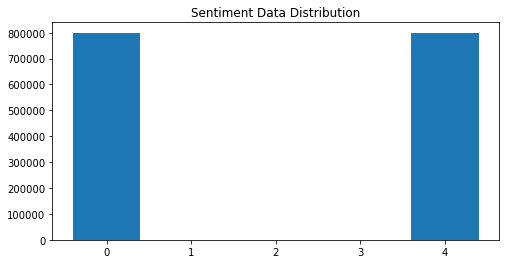

In [9]:
val_count = twitter.Sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Data Visualization

<AxesSubplot:ylabel='Frequency'>

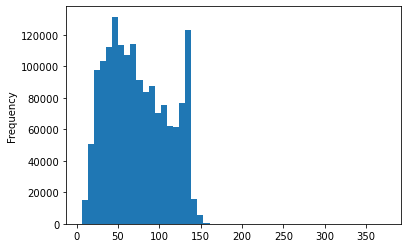

In [10]:
twitter['length'].plot(bins=50, kind='hist')

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>], dtype=object)

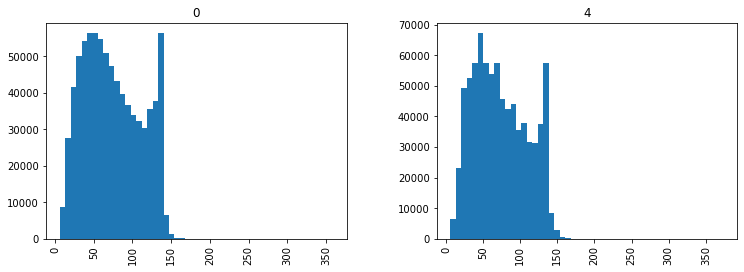

In [11]:
twitter.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

Very interesting! Through just basic EDA we've been able to discover a trend that positive messages tend to have more characters. 

Let's start processing the data so that we can eventually use SciKit Learn with it!

## Data Pre-processing

We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [12]:
twitter = twitter.drop(['Identification', 'Date & Time', 'Query', 'User', 'length'], axis=1)

In [13]:
lab_to_Sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_Sentiment[label]
twitter.Sentiment = twitter.Sentiment.apply(lambda x: label_decoder(x))
twitter.head()

,Sentiment,Text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [14]:
import random
random_idx_list = [random.randint(1,len(twitter.Text)) for i in range(10)] # creates random indexes to choose from dataframe
twitter.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,Sentiment,Text
1306572,Positive,er'body check out @girlwithnoname's new vlog &...
1537296,Positive,"@SarahFTW nope, if we waste any more time we'l..."
241691,Negative,My mom just asked me if I can skip training to...
653229,Negative,@LauraRIOT I can'ny find it
1266037,Positive,@humanpitbull lol ooopss my badd
208203,Negative,pokerface is stuck in my head. and im prettty ...
873458,Positive,just going to shop brb
529446,Negative,i need to go and exercise but i cant be bothered
1459204,Positive,I'm still excited for every new follower - the...
681676,Negative,@breatheheavycom why?? sold out already? i wan...


It appears that the text data is bad quality for use. because we frequently employ words without context and numerous punctuation marks. It is useless as a feature for the model we are building. Therefore, we must get rid of them.

## Text Pre-processing

The fact that all of our data is in text format is our major problem (strings). The classification task will be carried out by the classification algorithms that we have learned about so far using some kind of numerical feature vector. A corpus can be converted to a vector format using a variety of techniques. The [bag-of-words] technique, where each distinct word in a text is represented by one integer, is the simplest.

The raw messages (sequence of characters) will be converted into vectors in this phase (sequences of numbers).

Let's start by creating a function that breaks down a message into its component words and returns a list. We'll also get rid of words like "the" and "a," etc. We will make use of the NLTK library to accomplish this. It is essentially the default Python text processing module and includes a tonne of helpful features. Here, we'll merely employ a few of the fundamental ones.

Create a method to handle the text in the message column, and then use pandas' **apply()** function to handle all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [15]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Stemming, Lemitization and removal of stop words

Stemming - Stemming is the process of reducing inflected or derived words to their word stem or root.

Lemitization - Lemmatizing is the process of returning a word to its dictionary form by removing inflectional endings. Although it requires more resources, this text cleaning technique is more accurate.

In [16]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [17]:
twitter.Text = twitter.Text.apply(lambda x: preprocess(x))

**Now our data has been cleaned, now its neat and tidy.**

## Train and Test Split

In [18]:
Train_Size = 0.7
Sequence_Length = 30

In [19]:
train_data, test_data = train_test_split(twitter, test_size=1-Train_Size,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size: ", len(test_data))

Train Data size: 1119999
Test Data size:  480001


train_test_split will partition the dataset into training and testing portions after shuffling it. Before training, we must shuffle our dataset.

In [20]:
train_data.head(10)

,Sentiment,Text
76880,Negative,want mario kart guitar hero wii
976921,Positive,kareoke bohemian rhapsody chris
1457834,Positive,larry possible creative umbrella company leisu...
1264122,Positive,hey chelsea
912696,Positive,happy mothers day grown n happy amp lil prego ...
1555914,Positive,never seen gotta see sandra bullock
1215136,Positive,tjtee bing something would replies called bong...
235662,Negative,ossim night church needs study japanese
1343953,Positive,wow thank sherry nicest thing anyone ever said...
938238,Positive,finally home


## Tokenization

Tokenization is the process of breaking down a character sequence into smaller units, known as tokens, sometimes while also removing some characters, like punctuation. Tokenization is the term for the procedure.

In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.Text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 266804


In [22]:
from keras_preprocessing.sequence import pad_sequences


x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text),
                        maxlen = Sequence_Length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text),
                       maxlen = Sequence_Length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1119999, 30)
Testing X Shape: (480001, 30)


### Label Encoding

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.Sentiment.to_list())

y_train = encoder.transform(train_data.Sentiment.to_list())
y_test = encoder.transform(test_data.Sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1119999, 1)
y_test shape: (480001, 1)


## Word Embedding

Words are shown in Language Model in a way that intends for greater significance and helps learners acquire the patterns and contextual meanings associated with them.

One of the widely used methods of document vocabulary encoding is word embedding.

It can identify a word's position in a document, its semantic and syntactic similarities, its relationship to other words, etc.

We will be using GloVe Embedding, which can be found here https://github.com/stanfordnlp/GloVe

In [24]:
Glove = 'glove.6B.300d.txt'
Embedding = 300
LR = 1e-3
Batch_Size = 1024
Epochs = 10

In [25]:
embeddings_index = {}

f = open(Glove, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400001 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, Embedding))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          Embedding,
                                          weights=[embedding_matrix],
                                          input_length=Sequence_Length,
                                          trainable=False)

## Model Training using LTSM

Our Deep Learning model can now be built. Key considerations including Model Architecture, Hyperparmeter Tuning, and Model Performance should be kept in mind when creating DL models.

The word cloud shows that some words are frequently used in both positive and negative tweets. If we employ a machine learning model like Naive Bayes, SVD, etc., this can be a problem. We employ sequence models for this reason.

### Sequence Model

Reccurent neural networks can process a data sequence and learn a pattern of input sequence to produce either a data sequence or a scalar value as output. In this instance, the neural network predicts a scalar value.

In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
sequence_input = Input(shape=(Sequence_Length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

### Optimization and Callbacks

Adam, a gradient descent optimization algorithm, is used in this notebook.

At the end of an epoch, callbacks are special functions that are invoked. After each epoch, we can employ any functions to carry out a certain operation. We will be using two callbacks, LRScheduler and ModelCheckPoint.

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

**Let's start training... It takes a long time if training with CPU so lets use our GPU if available.**

In [31]:
print("Training on GPU ") if tf.test.is_gpu_available() else print("Training on CPU ")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU 


In [33]:
history = model.fit(x_train, y_train, batch_size=Batch_Size, epochs=Epochs,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1094/1094 [==============================] - 1412s 1s/step - loss: 0.5218 - accuracy: 0.7370 - val_loss: 0.4835 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 2/10
1094/1094 [==============================] - 1242s 1s/step - loss: 0.4900 - accuracy: 0.7607 - val_loss: 0.4726 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 3/10
1094/1094 [==============================] - 1265s 1s/step - loss: 0.4790 - accuracy: 0.7682 - val_loss: 0.4677 - val_accuracy: 0.7746 - lr: 0.0010
Epoch 4/10
1094/1094 [==============================] - 1376s 1s/step - loss: 0.4728 - accuracy: 0.7722 - val_loss: 0.4646 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 5/10
1094/1094 [==============================] - 1255s 1s/step - loss: 0.4684 - accuracy: 0.7752 - val_loss: 0.4640 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 6/10
1094/1094 [==============================] - 1350s 1s/step - loss: 0.4643 - accuracy: 0.7778 - val_loss: 0.4610 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 7/10
1094/1094 [========================

## Model Evaluation

We can assess the model's performance now that it has been trained. To put the model to the test, we'll use several evaluation metrics and procedures.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

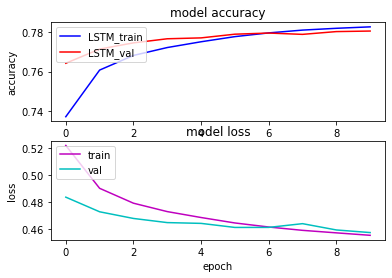

In [34]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will generate a prediction score that ranges from 0 to 1. By establishing a threshold value for it, we can categorise two classes. In our situation, I've specified a THRESHOLD value of 0.5 if the score is higher. It will then be categorised as a POSITIVE feeling.

In [36]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

49/49 [==============================] - 115s 2s/step


## Confusion Matrix

A excellent overview of the model's performance in the classification job is provided by the confusion matrix.

In [37]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):
  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True ', fontsize=15)
    plt.xlabel('Predicted ', fontsize=15)

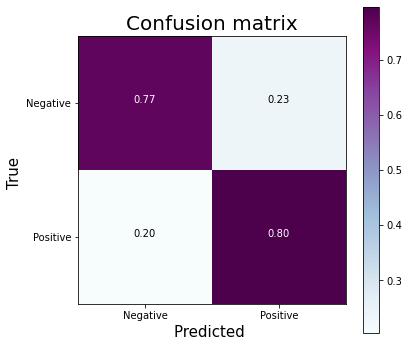

In [38]:
cnf_matrix = confusion_matrix(test_data.Sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.Sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [39]:
print(classification_report(list(test_data.Sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    240832
    Positive       0.77      0.80      0.78    239169

    accuracy                           0.78    480001
   macro avg       0.78      0.78      0.78    480001
weighted avg       0.78      0.78      0.78    480001



In terms of NLP, the model we trained here is quite effective. Given that humans typically perform these activities with a very low baseline accuracy, about 80% accuracy is sufficient. You can continue to look through the dataset because some tweets can be in languages other than English. Therefore, our tokenizing and embedding won't affect them. However, in a real-world setting, this model is capable of performing the majority of sentiment analysis tasks.